In [34]:

import pandas as pd
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

ted = pd.read_csv("ted_main.csv")
trans = pd.read_csv("transcripts.csv")

ted['ratings'] = ted['ratings'].apply(ast.literal_eval)
ted['tags'] = ted['tags'].apply(ast.literal_eval)

ted['film_date'] = pd.to_datetime(ted['film_date'], unit='s')
ted['published_date'] = pd.to_datetime(ted['published_date'], unit='s')
ted['year'] = ted['film_date'].dt.year
ted['duration_min'] = ted['duration'] / 60


def count_rating_groups(ratings):
    negative = ['Longwinded', 'Confusing', 'Unconvincing', 'Obnoxious']
    positive = ["Beautiful", "Courageous", "Fascinating", "Funny",
                "Informative", "Ingenious", "Inspiring", "Persuasive", "Jaw-dropping"]
    neutral = ['OK']
    
    counts = {r['name']: r['count'] for r in ratings}
    neg = sum([counts.get(n, 0) for n in negative])
    pos = sum([counts.get(p, 0) for p in positive])
    neu = sum([counts.get(nu, 0) for nu in neutral])
    
    return pd.Series([neg, pos, neu])

ted[['neg_count', 'pos_count', 'neu_count']] = ted['ratings'].apply(count_rating_groups)

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # bỏ dấu câu, số, ký tự đặc biệt
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

merged = pd.merge(ted, trans, on='url', how='inner')

merged['cleaned_transcript'] = merged['transcript'].apply(clean_text)


merged['transcript_word_count'] = merged['transcript'].apply(lambda x: len(str(x).split()))


print("Số bài TED gốc:", ted.shape[0])
print("Số bài transcript gốc:", trans.shape[0])
print("Số bài sau merge:", merged.shape[0])

merged.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Số bài TED gốc: 2550
Số bài transcript gốc: 2467
Số bài sau merge: 2467


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,url,views,year,duration_min,neg_count,pos_count,neu_count,transcript,cleaned_transcript,transcript_word_count
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,2006-02-25,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,2006-06-27 00:11:00,...,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,2006,19.400000,1138,91538,1174,Good morning. How are you?(Laughter)It's been ...,good morning youlaughterits great hasnt ive bl...,3066
1,265,With the same humor and humanity he exuded in ...,977,TED2006,2006-02-25,43,Al Gore,Al Gore: Averting the climate crisis,1,2006-06-27 00:11:00,...,https://www.ted.com/talks/al_gore_on_averting_...,3200520,2006,16.283333,564,2169,203,"Thank you so much, Chris. And it's truly a gre...",thank much chris truly great honor opportunity...,2089
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,2006-02-24,26,David Pogue,David Pogue: Simplicity sells,1,2006-06-27 00:11:00,...,https://www.ted.com/talks/david_pogue_says_sim...,1636292,2006,21.433333,351,2327,146,"(Music: ""The Sound of Silence,"" Simon & Garfun...",music sound silence simon garfunkelhello voice...,3253
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,2006-02-26,35,Majora Carter,Majora Carter: Greening the ghetto,1,2006-06-27 00:11:00,...,https://www.ted.com/talks/majora_carter_s_tale...,1697550,2006,18.600000,156,3487,85,If you're here today — and I'm very happy that...,youre today happy youve heard sustainable deve...,3015
4,593,You've never seen data presented like this. Wi...,1190,TED2006,2006-02-22,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,2006-06-27 20:38:00,...,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,2006,19.833333,310,25062,248,"About 10 years ago, I took on the task to teac...",year ago took task teach global development sw...,3121


In [35]:
merged['total_rating_count'] = merged[['neg_count', 'pos_count', 'neu_count']].sum(axis=1)
merged['neg_ratio'] = merged['neg_count'] / merged['total_rating_count']


In [36]:
neg_dominant = merged[merged['neg_ratio'] > 0.2]
print(f"Số bài có tỷ lệ đánh giá tiêu cực > 20%: {neg_dominant.shape[0]}")


Số bài có tỷ lệ đánh giá tiêu cực > 20%: 177


In [37]:

data = neg_dominant.copy()


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
X_tfidf = tfidf.fit_transform(data['cleaned_transcript'])

mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_idx = mean_tfidf.argsort()[::-1][:30]
top_keywords = [tfidf.get_feature_names_out()[i] for i in top_idx]
top_scores = mean_tfidf[top_idx]

print("Top 30 từ khóa đặc trưng của 177 bài có tỉ lệ đánh giá tiêu cực cao:")
for word, score in zip(top_keywords, top_scores):
    print(f"{word}: {score:.4f}")


Top 30 từ khóa đặc trưng của 177 bài có tỉ lệ đánh giá tiêu cực cao:
thing: 0.0601
think: 0.0569
going: 0.0505
world: 0.0467
really: 0.0454
thats: 0.0436
kind: 0.0408
way: 0.0396
make: 0.0390
year: 0.0389
actually: 0.0369
dont: 0.0359
want: 0.0345
city: 0.0325
say: 0.0319
look: 0.0310
work: 0.0293
need: 0.0289
youre: 0.0287
right: 0.0280
lot: 0.0277
new: 0.0273
said: 0.0272
life: 0.0270
little: 0.0270
idea: 0.0269
story: 0.0266
design: 0.0261
got: 0.0260
come: 0.0258


In [39]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
X_bow = vectorizer.fit_transform(data['cleaned_transcript'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_bow)

def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nChủ đề {idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)



Chủ đề 1:
people, thing, like, going, know, think, kind, really, thats, want

Chủ đề 2:
know, thing, like, think, people, dont, thats, world, way, say

Chủ đề 3:
people, think, world, actually, year, thing, city, going, really, thats

Chủ đề 4:
people, like, city, need, work, actually, thats, time, look, war

Chủ đề 5:
like, thing, brain, language, woman, really, look, people, thats, year


In [40]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_vectorizer = CountVectorizer(ngram_range=(2, 3), min_df=3, stop_words='english')
X_ngrams = ngram_vectorizer.fit_transform(data['cleaned_transcript'])

sum_ngrams = X_ngrams.sum(axis=0).A1
ngram_freq = list(zip(ngram_vectorizer.get_feature_names_out(), sum_ngrams))

ngram_freq_sorted = sorted(ngram_freq, key=lambda x: x[1], reverse=True)

print(" Các cụm từ (n-grams) phổ biến với tổng số lần xuất hiện:")
print(f"{'Cụm từ':40s} {'Tổng số lần':>10s}")
for phrase, freq in ngram_freq_sorted[:20]:
    print(f"{phrase:40s} {freq:10d}")


 Các cụm từ (n-grams) phổ biến với tổng số lần xuất hiện:
Cụm từ                                   Tổng số lần
year ago                                        147
dont know                                       142
little bit                                      141
look like                                       108
united state                                    105
new york                                         79
thing like                                       72
youve got                                        64
dont want                                        57
weve got                                         57
youre going                                      56
dont think                                       45
lot people                                       43
whats going                                      43
think thats                                      41
ive got                                          40
kind thing                                       40
tell 

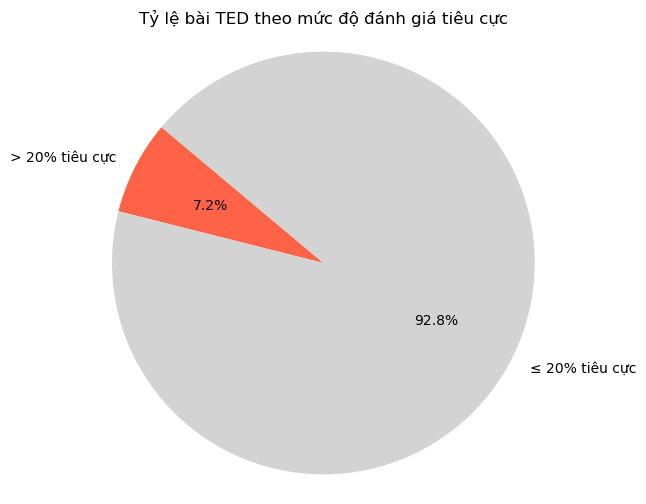

In [41]:
import matplotlib.pyplot as plt

count_over_20 = (merged['neg_ratio'] > 0.2).sum()
count_under_equal_20 = (merged['neg_ratio'] <= 0.2).sum()

labels = ['> 20% tiêu cực', '≤ 20% tiêu cực']
sizes = [count_over_20, count_under_equal_20]
colors = ['tomato', 'lightgray']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Tỷ lệ bài TED theo mức độ đánh giá tiêu cực')
plt.axis('equal') 
plt.show()


In [42]:

keywords = ['think', 'want', 'dont']

def count_keywords(text, keywords):
    text = text.lower()
    return sum(text.count(word) for word in keywords)

neg_dominant['keyword_count'] = neg_dominant['cleaned_transcript'].apply(lambda x: count_keywords(x, keywords))

neg_dominant_sorted = neg_dominant.sort_values(by='keyword_count', ascending=False)

top_example = neg_dominant_sorted.iloc[0]

print(f"URL bài nói: {top_example['url']}")
print(f"Tỷ lệ tiêu cực: {top_example['neg_ratio']:.2%}")
print(f"Số lần xuất hiện từ khóa {keywords}: {top_example['keyword_count']}")
print(f"Tiêu đề: {top_example['title']}")
print(f"Transcript (tóm tắt):\n{top_example['cleaned_transcript'][:500]}...")  # In 500 ký tự đầu


URL bài nói: https://www.ted.com/talks/the_inspiration_of_second_life

Tỷ lệ tiêu cực: 29.98%
Số lần xuất hiện từ khóa ['think', 'want', 'dont']: 61
Tiêu đề: Life in Second Life
Transcript (tóm tắt):
know going thing little differently going show presentation going talk time going look image photo stream pretty close live thing snapshot second life hopefully fascinating compete attention strange picture see screen come thought talk little bit big idea get john back talk interactively little bit think ask question know guess first question build virtual world think answer always going least driven certain extent people initially crazy enough start project knowso give little bit first backgrou...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7820\1125871672.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_dominant['keyword_count'] = neg_dominant['cleaned_transcript'].apply(lambda x: count_keywords(x, keywords))


In [43]:
print(f"Toàn bộ nội dung transcript của bài:\n\n{top_example['transcript']}")


Toàn bộ nội dung transcript của bài:

You know, we're going to do things a little differently. I'm not going to show you a presentation. I'm going to talk to you. And at the same time, we're going to look at just images from a photo stream that is pretty close to live of things that — snapshots from Second Life. So hopefully this will be fascinating. You can — I can compete for your attention with the strange pictures that you see on screen that come from there. I thought I'd talk a little bit about some just big ideas about this, and then get John back out here so we can talk interactively a little bit more and think and ask questions. You know, I guess the first question is, why build a virtual world at all? And I think the answer to that is always going to be at least driven to a certain extent by the people initially crazy enough to start the project, you know.So I can give you a little bit of first background just on me and what moved me as a — really going back as far as a teenag

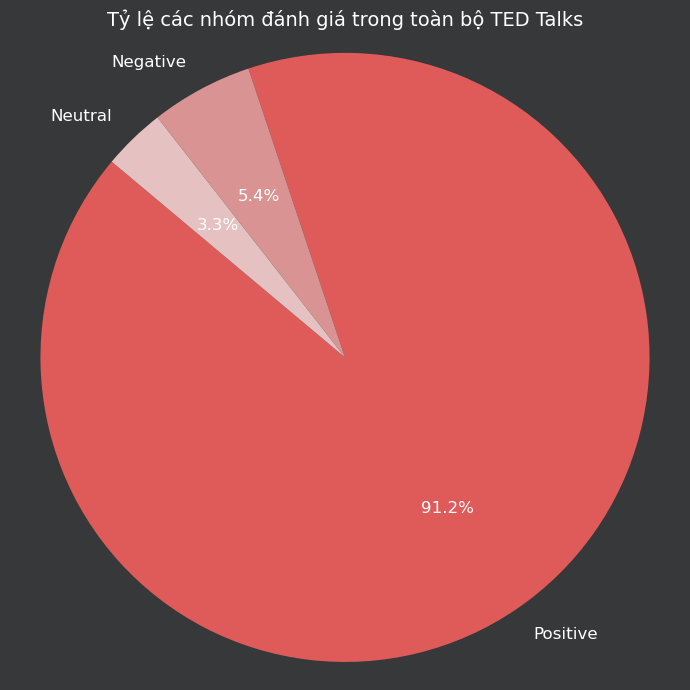

In [44]:
import matplotlib.pyplot as plt

total_neg = merged['neg_count'].sum()
total_neu = merged['neu_count'].sum()
total_pos = merged['pos_count'].sum()

sizes = [total_pos, total_neg, total_neu]
labels = ['Positive', 'Negative', 'Neutral']
colors = ['#de5b59', '#d99392', '#e5c1c1']  


plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct='%1.1f%%',
    startangle=140,
    textprops={'color': 'white', 'fontsize': 12}
)


plt.title('Tỷ lệ các nhóm đánh giá trong toàn bộ TED Talks', color='white', fontsize=14)
plt.axis('equal')  
plt.gca().set_facecolor('#373839')
plt.gcf().set_facecolor('#373839')  
plt.tight_layout()
plt.show()



In [45]:
pos_dominant = merged[merged['pos_count'] / (merged['pos_count'] + merged['neg_count'] + merged['neu_count']) > 0.8]
print(f"Số bài có tỷ lệ đánh giá tích cực > 80%: {pos_dominant.shape[0]}")


Số bài có tỷ lệ đánh giá tích cực > 80%: 2042


In [46]:
pos_sample = pos_dominant.sample(n=177, random_state=42)


In [47]:
data_pos = pos_sample.copy()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_pos = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
X_pos_tfidf = tfidf_pos.fit_transform(data_pos['cleaned_transcript'])

mean_tfidf_pos = np.asarray(X_pos_tfidf.mean(axis=0)).ravel()
top_idx_pos = mean_tfidf_pos.argsort()[::-1][:30]
top_keywords_pos = [(tfidf_pos.get_feature_names_out()[i], mean_tfidf_pos[i]) for i in top_idx_pos]

print("🔑 Từ khóa đặc trưng trong nhóm tích cực:")
for word, score in top_keywords_pos:
    print(f"{word}: {score:.4f}")


🔑 Từ khóa đặc trưng trong nhóm tích cực:
thing: 0.0424
year: 0.0415
going: 0.0402
thats: 0.0402
really: 0.0389
world: 0.0371
think: 0.0369
dont: 0.0343
actually: 0.0332
life: 0.0329
said: 0.0329
want: 0.0328
make: 0.0326
say: 0.0300
way: 0.0297
right: 0.0288
need: 0.0283
child: 0.0257
new: 0.0253
day: 0.0253
woman: 0.0252
lot: 0.0250
come: 0.0241
look: 0.0240
youre: 0.0240
kind: 0.0239
human: 0.0238
theyre: 0.0237
work: 0.0234
little: 0.0231


In [49]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_vectorizer_pos = CountVectorizer(ngram_range=(2, 3), min_df=3, stop_words='english')
X_pos_ngrams = ngram_vectorizer_pos.fit_transform(data_pos['cleaned_transcript'])

sum_ngrams_pos = X_pos_ngrams.sum(axis=0).A1
ngram_freq_pos = list(zip(ngram_vectorizer_pos.get_feature_names_out(), sum_ngrams_pos))

ngram_freq_sorted_pos = sorted(ngram_freq_pos, key=lambda x: x[1], reverse=True)

print("\n Các cụm từ (n-grams) phổ biến trong nhóm tích cực:")
print(f"{'Cụm từ':40s} {'Tổng số lần':>10s}")
for phrase, freq in ngram_freq_sorted_pos[:20]:
    print(f"{phrase:40s} {freq:10d}")



 Các cụm từ (n-grams) phổ biến trong nhóm tích cực:
Cụm từ                                   Tổng số lần
year ago                                        152
dont know                                       116
little bit                                      100
look like                                        97
united state                                     89
youre going                                      66
year old                                         56
dont want                                        54
new york                                         51
thing like                                       47
youve got                                        47
health care                                      44
weve got                                         43
didnt know                                       41
young people                                     41
feel like                                        40
high school                                      38
lot people

In [50]:
# Đưa về dạng DataFrame
df_neg = pd.DataFrame(ngram_freq_sorted[:100], columns=["ngram", "neg_freq"])
df_pos = pd.DataFrame(ngram_freq_sorted_pos[:100], columns=["ngram", "pos_freq"])

merged_ngrams = pd.merge(df_neg, df_pos, on='ngram', how='outer').fillna(0)

merged_ngrams['diff'] = merged_ngrams['neg_freq'] - merged_ngrams['pos_freq']
merged_ngrams = merged_ngrams.sort_values(by='diff', ascending=False)

print("Các cụm từ phổ biến hơn rõ rệt ở nhóm tiêu cực:")
print(merged_ngrams.head(15)[['ngram', 'neg_freq', 'pos_freq', 'diff']])


Các cụm từ phổ biến hơn rõ rệt ở nhóm tiêu cực:
               ngram  neg_freq  pos_freq  diff
133      whats going      43.0       0.0  43.0
118      think thats      41.0       0.0  41.0
59        little bit     141.0     100.0  41.0
124        want know      36.0       0.0  36.0
70        make thing      36.0       0.0  36.0
25   economic growth      35.0       0.0  35.0
102         ted talk      35.0       0.0  35.0
129        way think      31.0       0.0  31.0
78          new york      79.0      51.0  28.0
111      thing going      27.0       0.0  27.0
18         dont know     142.0     116.0  26.0
113     thing really      25.0       0.0  25.0
112       thing like      72.0      47.0  25.0
49         know know      25.0       0.0  25.0
32        going make      25.0       0.0  25.0


In [51]:
from collections import Counter


all_tags = sum(neg_dominant['tags'], [])  # Vì mỗi phần tử là 1 list, nên dùng sum để nối

tag_counts = Counter(all_tags)

print("Các chủ đề phổ biến nhất trong 177 bài tiêu cực:")
for tag, count in tag_counts.most_common(10):
    print(f"{tag}: {count}")


Các chủ đề phổ biến nhất trong 177 bài tiêu cực:
technology: 58
design: 57
culture: 52
global issues: 42
business: 33
entertainment: 26
TEDx: 25
art: 24
cities: 22
science: 21


In [52]:
merged['total_ratings'] = merged['neg_count'] + merged['pos_count'] + merged['neu_count']
merged['pos_ratio'] = merged['pos_count'] / merged['total_ratings']


In [53]:

top_positive = merged.sort_values(by='pos_ratio', ascending=False).head(177)

from collections import Counter
tag_counter_pos = Counter()

for tags in top_positive['tags']:
    tag_counter_pos.update(tags)

print("Các chủ đề phổ biến trong 177 bài tích cực:")
for tag, count in tag_counter_pos.most_common(10):
    print(f"{tag:20s}: {count}")


Các chủ đề phổ biến trong 177 bài tích cực:
TEDx                : 41
technology          : 37
science             : 32
culture             : 26
global issues       : 26
health              : 26
design              : 26
social change       : 25
children            : 24
humanity            : 23


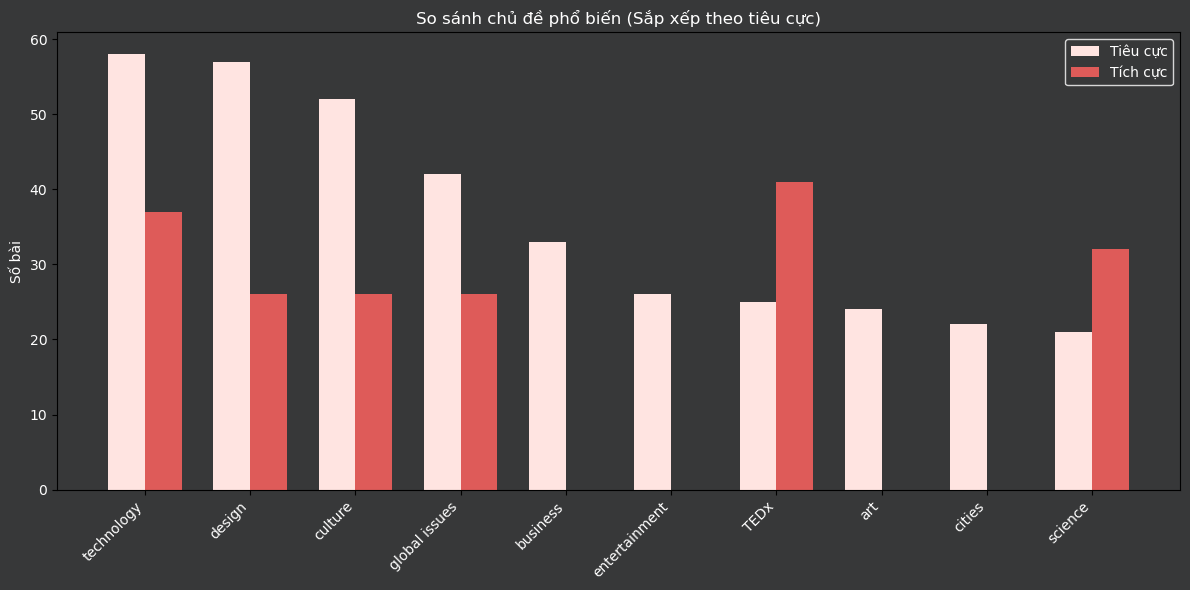

In [54]:
import matplotlib.pyplot as plt

neg_tags = {
    'technology': 58, 'design': 57, 'culture': 52, 'global issues': 42,
    'business': 33, 'entertainment': 26, 'TEDx': 25, 'art': 24,
    'cities': 22, 'science': 21
}

pos_tags = {
    'TEDx': 41, 'technology': 37, 'science': 32, 'culture': 26,
    'global issues': 26, 'health': 26, 'design': 26,
    'social change': 25, 'children': 24, 'humanity': 23
}

all_topics_sorted = sorted(neg_tags.items(), key=lambda x: x[1], reverse=True)
topics_sorted = [t[0] for t in all_topics_sorted]

neg_values = [neg_tags.get(tag, 0) for tag in topics_sorted]
pos_values = [pos_tags.get(tag, 0) for tag in topics_sorted]

x = range(len(topics_sorted))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in x], neg_values, width=bar_width, color="#ffe4e1", label="Tiêu cực")
plt.bar([i + bar_width/2 for i in x], pos_values, width=bar_width, color='#de5b59', label="Tích cực")

plt.xticks(x, topics_sorted, rotation=45, ha='right', color='white')  # Chủ đề màu trắng
plt.yticks(color='white')  # Trục y màu trắng
plt.ylabel("Số bài", color='white')
plt.title("So sánh chủ đề phổ biến (Sắp xếp theo tiêu cực)", color='white')

plt.gca().set_facecolor('#373839')  
plt.gcf().set_facecolor('#373839')  
plt.legend(facecolor='#373839', edgecolor='white', labelcolor='white')
plt.tight_layout()
plt.show()


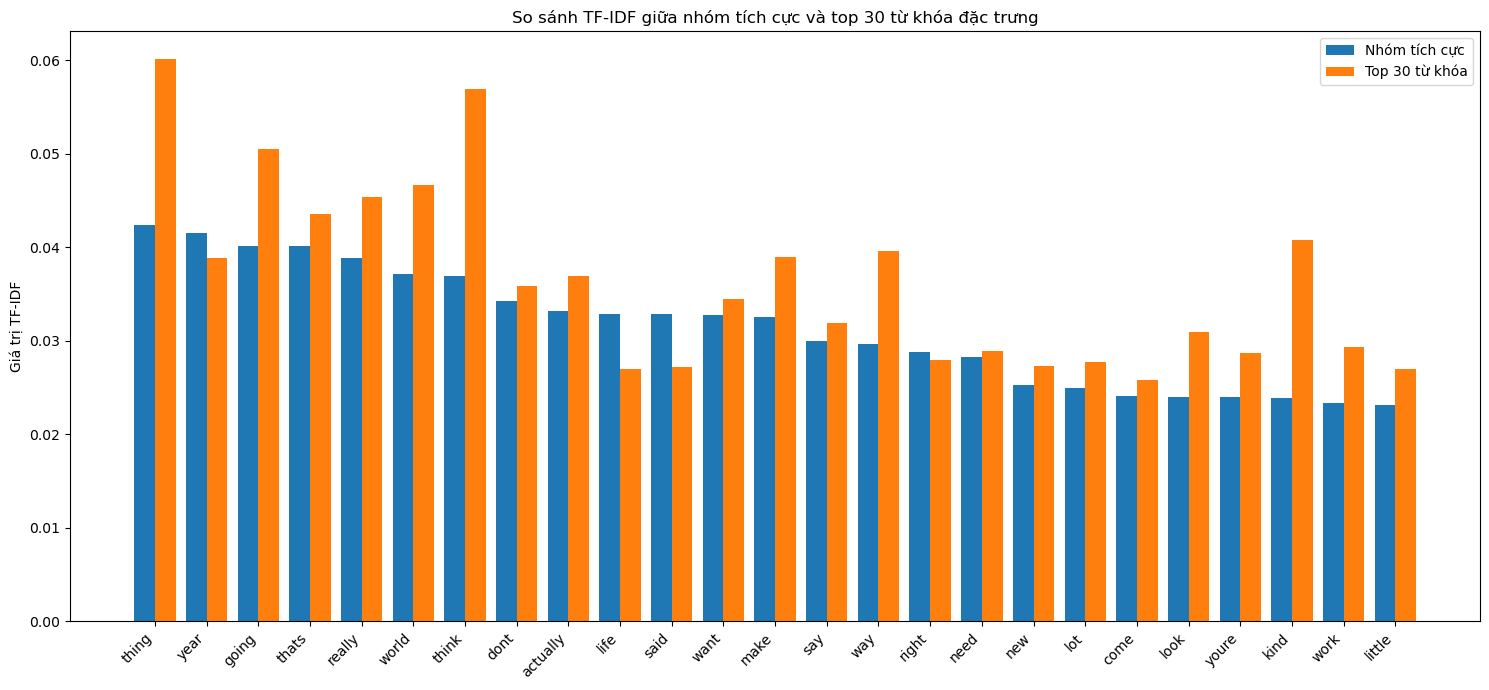

In [55]:
import matplotlib.pyplot as plt
import numpy as np

words_positive = [
    "thing", "year", "going", "thats", "really", "world", "think", "dont", "actually", "life",
    "said", "want", "make", "say", "way", "right", "need", "child", "new", "day",
    "woman", "lot", "come", "look", "youre", "kind", "human", "theyre", "work", "little"
]

tfidf_positive = [
    0.0424, 0.0415, 0.0402, 0.0402, 0.0389, 0.0371, 0.0369, 0.0343, 0.0332, 0.0329,
    0.0329, 0.0328, 0.0326, 0.0300, 0.0297, 0.0288, 0.0283, 0.0257, 0.0253, 0.0253,
    0.0252, 0.0250, 0.0241, 0.0240, 0.0240, 0.0239, 0.0238, 0.0237, 0.0234, 0.0231
]

words_top30 = [
    "thing", "think", "going", "world", "really", "thats", "kind", "way", "make", "year",
    "actually", "dont", "want", "city", "say", "look", "work", "need", "youre", "right",
    "lot", "new", "said", "life", "little", "idea", "story", "design", "got", "come"
]

tfidf_top30 = [
    0.0601, 0.0569, 0.0505, 0.0467, 0.0454, 0.0436, 0.0408, 0.0396, 0.0390, 0.0389,
    0.0369, 0.0359, 0.0345, 0.0325, 0.0319, 0.0310, 0.0293, 0.0289, 0.0287, 0.0280,
    0.0277, 0.0273, 0.0272, 0.0270, 0.0270, 0.0269, 0.0266, 0.0261, 0.0260, 0.0258
]

common_words = list(set(words_positive) & set(words_top30))
common_words.sort(key=lambda x: (words_positive.index(x), words_top30.index(x)))  # Giữ thứ tự từ positive

pos_indices = [words_positive.index(w) for w in common_words]
top30_indices = [words_top30.index(w) for w in common_words]

pos_values = [tfidf_positive[i] for i in pos_indices]
top30_values = [tfidf_top30[i] for i in top30_indices]

x = np.arange(len(common_words))
width = 0.4

fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, pos_values, width, label='Nhóm tích cực')
rects2 = ax.bar(x + width/2, top30_values, width, label='Top 30 từ khóa')

ax.set_ylabel('Giá trị TF-IDF')
ax.set_title('So sánh TF-IDF giữa nhóm tích cực và top 30 từ khóa đặc trưng')
ax.set_xticks(x)
ax.set_xticklabels(common_words, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


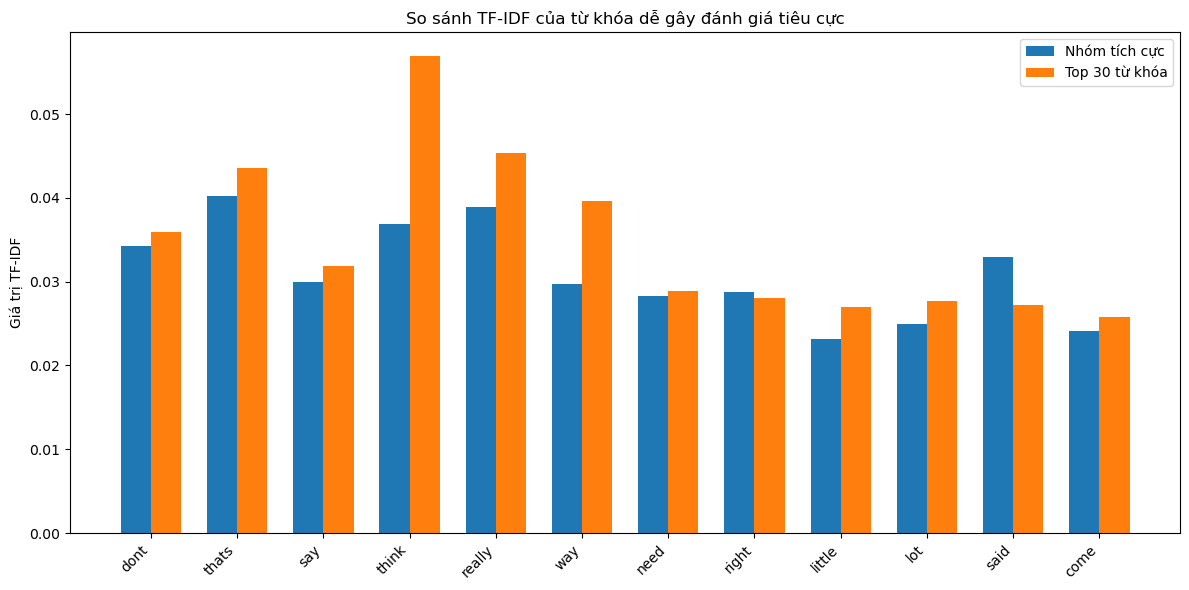

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Từ khóa dễ bị đánh giá tiêu cực bạn liệt kê
negative_like_words = [
    "dont", "thats", "say", "think", "really", "way",
    "need", "right", "little", "lot", "said", "come"
]

# Danh sách và giá trị TF-IDF nhóm tích cực
words_positive = [
    "thing", "year", "going", "thats", "really", "world", "think", "dont", "actually", "life",
    "said", "want", "make", "say", "way", "right", "need", "child", "new", "day",
    "woman", "lot", "come", "look", "youre", "kind", "human", "theyre", "work", "little"
]
tfidf_positive = [
    0.0424, 0.0415, 0.0402, 0.0402, 0.0389, 0.0371, 0.0369, 0.0343, 0.0332, 0.0329,
    0.0329, 0.0328, 0.0326, 0.0300, 0.0297, 0.0288, 0.0283, 0.0257, 0.0253, 0.0253,
    0.0252, 0.0250, 0.0241, 0.0240, 0.0240, 0.0239, 0.0238, 0.0237, 0.0234, 0.0231
]

# Danh sách và giá trị TF-IDF top 30
words_top30 = [
    "thing", "think", "going", "world", "really", "thats", "kind", "way", "make", "year",
    "actually", "dont", "want", "city", "say", "look", "work", "need", "youre", "right",
    "lot", "new", "said", "life", "little", "idea", "story", "design", "got", "come"
]
tfidf_top30 = [
    0.0601, 0.0569, 0.0505, 0.0467, 0.0454, 0.0436, 0.0408, 0.0396, 0.0390, 0.0389,
    0.0369, 0.0359, 0.0345, 0.0325, 0.0319, 0.0310, 0.0293, 0.0289, 0.0287, 0.0280,
    0.0277, 0.0273, 0.0272, 0.0270, 0.0270, 0.0269, 0.0266, 0.0261, 0.0260, 0.0258
]

# Lấy giá trị TF-IDF cho các từ khóa tiêu cực từ 2 danh sách, nếu không có thì cho 0
def get_tfidf(word_list, tfidf_list, word):
    return tfidf_list[word_list.index(word)] if word in word_list else 0

pos_values = [get_tfidf(words_positive, tfidf_positive, w) for w in negative_like_words]
top30_values = [get_tfidf(words_top30, tfidf_top30, w) for w in negative_like_words]

# Vẽ biểu đồ
x = np.arange(len(negative_like_words))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, pos_values, width, label='Nhóm tích cực')
rects2 = ax.bar(x + width/2, top30_values, width, label='Top 30 từ khóa')

ax.set_ylabel('Giá trị TF-IDF')
ax.set_title('So sánh TF-IDF của từ khóa dễ gây đánh giá tiêu cực')
ax.set_xticks(x)
ax.set_xticklabels(negative_like_words, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


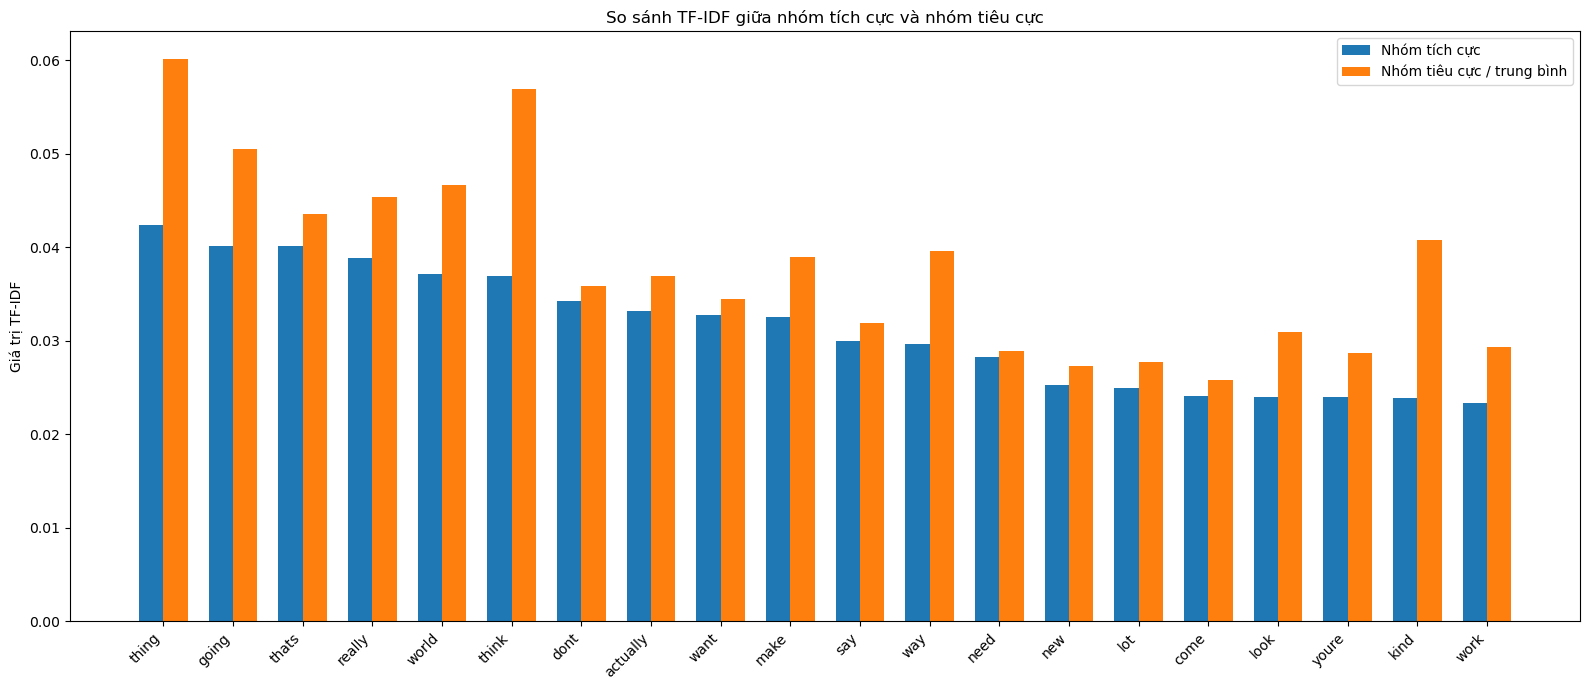

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Từ khóa được chọn
words = [
    "thing", "going", "thats", "really", "world", "think", "dont", "actually", "want",
    "make", "say", "way", "need", "new", "lot", "come", "look", "youre", "kind", "work"
]

# Giá trị TF-IDF nhóm tích cực (theo thứ tự từ trên)
tfidf_positive = [
    0.0424, 0.0402, 0.0402, 0.0389, 0.0371, 0.0369, 0.0343, 0.0332, 0.0328,
    0.0326, 0.0300, 0.0297, 0.0283, 0.0253, 0.0250, 0.0241, 0.0240, 0.0240, 0.0239, 0.0234
]

# Giá trị TF-IDF nhóm top 30 (tiêu cực/trung bình)
tfidf_top30 = [
    0.0601, 0.0505, 0.0436, 0.0454, 0.0467, 0.0569, 0.0359, 0.0369, 0.0345,
    0.0390, 0.0319, 0.0396, 0.0289, 0.0273, 0.0277, 0.0258, 0.0310, 0.0287, 0.0408, 0.0293
]

x = np.arange(len(words))
width = 0.35

plt.figure(figsize=(16,7))
plt.bar(x - width/2, tfidf_positive, width, label='Nhóm tích cực')
plt.bar(x + width/2, tfidf_top30, width, label='Nhóm tiêu cực / trung bình')
plt.xticks(x, words, rotation=45, ha='right')
plt.ylabel('Giá trị TF-IDF')
plt.title('So sánh TF-IDF giữa nhóm tích cực và nhóm tiêu cực')
plt.legend()
plt.tight_layout()
plt.show()


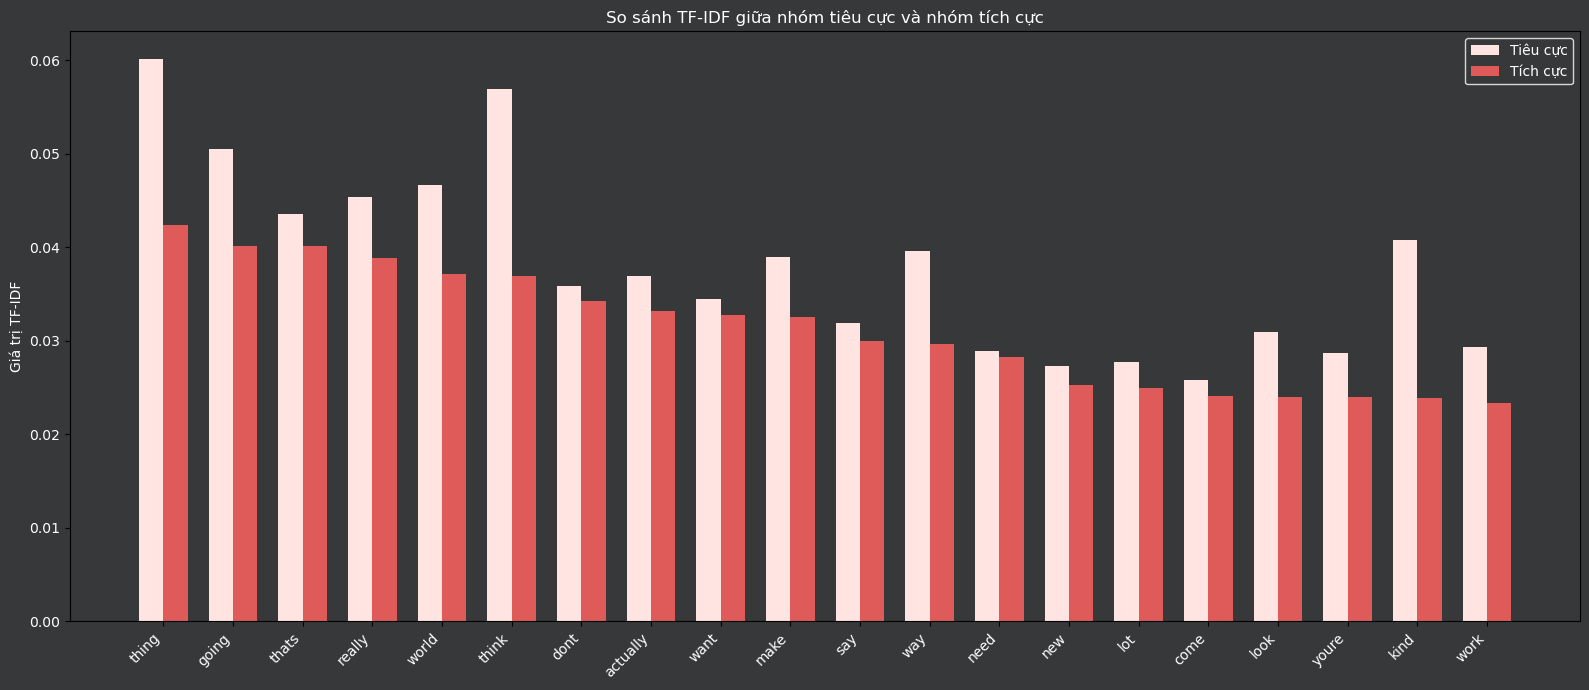

In [58]:
import matplotlib.pyplot as plt
import numpy as np

words = [
    "thing", "going", "thats", "really", "world", "think", "dont", "actually", "want",
    "make", "say", "way", "need", "new", "lot", "come", "look", "youre", "kind", "work"
]

tfidf_positive = [
    0.0424, 0.0402, 0.0402, 0.0389, 0.0371, 0.0369, 0.0343, 0.0332, 0.0328,
    0.0326, 0.0300, 0.0297, 0.0283, 0.0253, 0.0250, 0.0241, 0.0240, 0.0240, 0.0239, 0.0234
]

tfidf_negative = [
    0.0601, 0.0505, 0.0436, 0.0454, 0.0467, 0.0569, 0.0359, 0.0369, 0.0345,
    0.0390, 0.0319, 0.0396, 0.0289, 0.0273, 0.0277, 0.0258, 0.0310, 0.0287, 0.0408, 0.0293
]

x = np.arange(len(words))
bar_width = 0.35

plt.figure(figsize=(16,7))

plt.bar([i - bar_width/2 for i in x], tfidf_negative, width=bar_width, color="#ffe4e1", label="Tiêu cực")

plt.bar([i + bar_width/2 for i in x], tfidf_positive, width=bar_width, color='#de5b59', label="Tích cực")

plt.xticks(x, words, rotation=45, ha='right', color='white')
plt.yticks(color='white')
plt.ylabel("Giá trị TF-IDF", color='white')

plt.title("So sánh TF-IDF giữa nhóm tiêu cực và nhóm tích cực", color='white')

plt.gca().set_facecolor('#373839')
plt.gcf().set_facecolor('#373839')

plt.legend(facecolor='#373839', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()


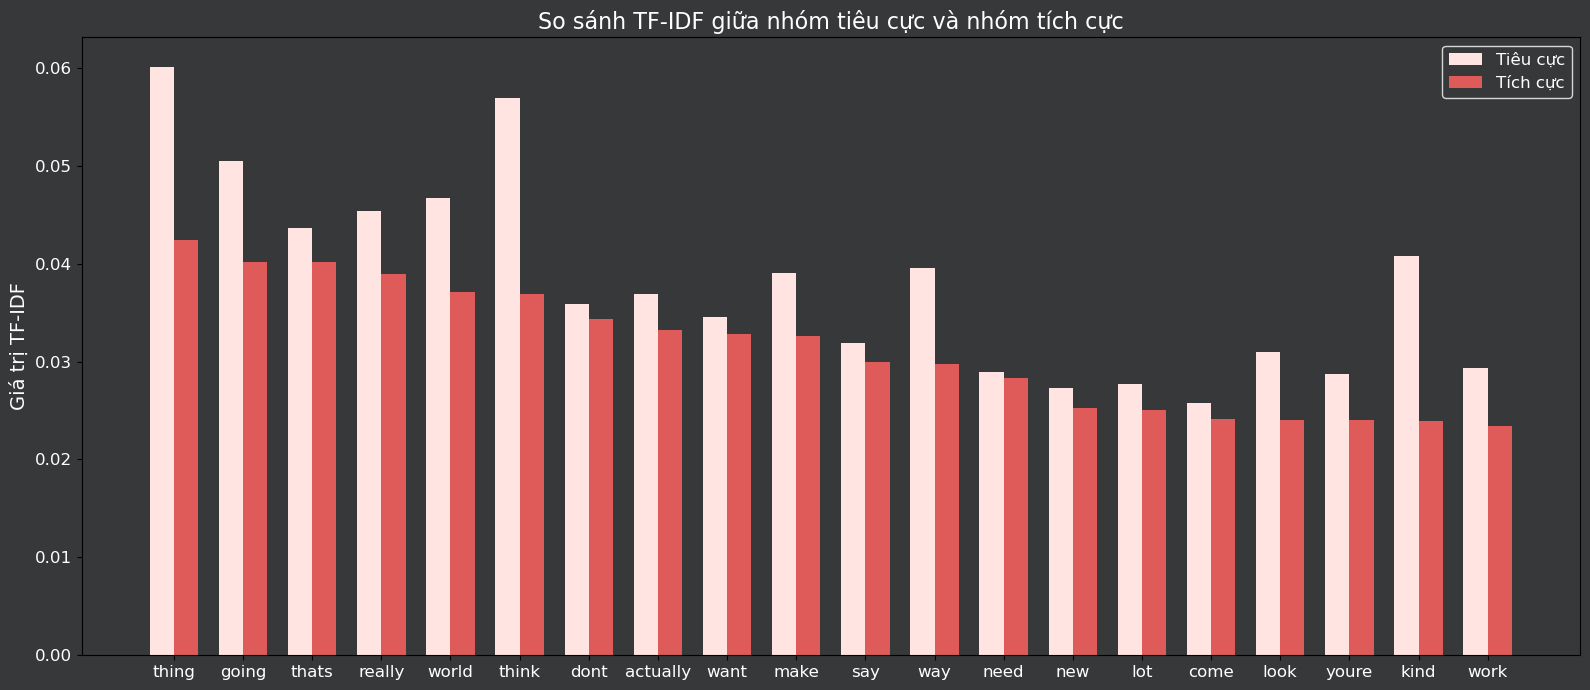

In [59]:
import matplotlib.pyplot as plt
import numpy as np

words = [
    "thing", "going", "thats", "really", "world", "think", "dont", "actually", "want",
    "make", "say", "way", "need", "new", "lot", "come", "look", "youre", "kind", "work"
]

tfidf_positive = [
    0.0424, 0.0402, 0.0402, 0.0389, 0.0371, 0.0369, 0.0343, 0.0332, 0.0328,
    0.0326, 0.0300, 0.0297, 0.0283, 0.0253, 0.0250, 0.0241, 0.0240, 0.0240, 0.0239, 0.0234
]

tfidf_negative = [
    0.0601, 0.0505, 0.0436, 0.0454, 0.0467, 0.0569, 0.0359, 0.0369, 0.0345,
    0.0390, 0.0319, 0.0396, 0.0289, 0.0273, 0.0277, 0.0258, 0.0310, 0.0287, 0.0408, 0.0293
]

x = np.arange(len(words))
bar_width = 0.35

plt.figure(figsize=(16, 7))

plt.bar([i - bar_width / 2 for i in x], tfidf_negative, width=bar_width, color="#ffe4e1", label="Tiêu cực")
plt.bar([i + bar_width / 2 for i in x], tfidf_positive, width=bar_width, color='#de5b59', label="Tích cực")


plt.xticks(x, words, rotation=0, ha='center', color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.ylabel("Giá trị TF-IDF", color='white', fontsize=14)
plt.title("So sánh TF-IDF giữa nhóm tiêu cực và nhóm tích cực", color='white', fontsize=16)
plt.legend(facecolor='#373839', edgecolor='white', labelcolor='white', fontsize=12)

plt.gca().set_facecolor('#373839')
plt.gcf().set_facecolor('#373839')

plt.tight_layout()
plt.show()
